# Magnetized Plasma in FDTD using ADE with Damping

## 1. Maxwell’s Equations in a Magnetized Plasma

The **current density** $\mathbf{J}$ in a plasma evolves dynamically under electric and magnetic fields.  

**Maxwell-Ampère equation:**

$$
\nabla \times \mathbf{H} = \epsilon_0 \frac{\partial \mathbf{E}}{\partial t} + \mathbf{J}
$$

**Electron motion under Lorentz force with damping:**

$$
m_e \frac{d\mathbf{v}}{dt} + m_e \nu \mathbf{v} = -e (\mathbf{E} + \mathbf{v} \times \mathbf{B}_0)
$$

- $\nu$ is the damping (collision) rate or stabilizing factor  
- $\mathbf{B}_0$ is the static magnetic field  
- $m_e$, $e$ are electron mass and charge  

Current density:

$$
\mathbf{J} = -e n_e \mathbf{v}
$$

---

## 2. ADE for a Damped Magnetized Plasma

Introducing the **Auxiliary Differential Equation** (ADE) for $\mathbf{J}$ with damping:

$$
\frac{d\mathbf{J}}{dt} + \nu \mathbf{J} + \mathbf{\Omega} \times \mathbf{J} = \epsilon_0 \omega_p^2 \mathbf{E}
$$

where:  

- $\mathbf{\Omega} = \omega_c \hat{\mathbf{B}}_0$ (cyclotron frequency vector)  
- $\omega_p$ is the plasma frequency  
- $\nu$ is the damping rate  

This **damping term** $\nu \mathbf{J}$ helps **stabilize the FDTD update** near resonances.

Maxwell’s equations become:

$$
\begin{aligned}
\epsilon_0 \frac{\partial \mathbf{E}}{\partial t} &= \nabla \times \mathbf{H} - \mathbf{J} \\
\mu_0 \frac{\partial \mathbf{H}}{\partial t} &= -\nabla \times \mathbf{E} \\
\frac{d\mathbf{J}}{dt} + \nu \mathbf{J} + \mathbf{\Omega} \times \mathbf{J} &= \epsilon_0 \omega_p^2 \mathbf{E}
\end{aligned}
$$

---

## 3. FDTD Update Scheme with Damping

At each time step:

1. **Update magnetic field**:

$$
\mathbf{H}^{n+1/2} = \mathbf{H}^{n-1/2} - \frac{\Delta t}{\mu_0} \nabla \times \mathbf{E}^n
$$

2. **Update plasma current** (explicit Euler):

$$
\mathbf{J}^{n+1} = \mathbf{J}^{n} + \Delta t \left( \epsilon_0 \omega_p^2 \mathbf{E}^n - \nu \mathbf{J}^{n} - \mathbf{\Omega} \times \mathbf{J}^{n} \right)
$$

> Optionally, we can use **semi-implicit or trapezoidal integration** for better stability.

3. **Update electric field**:

$$
\mathbf{E}^{n+1} = \mathbf{E}^n + \frac{\Delta t}{\epsilon_0} \left( \nabla \times \mathbf{H}^{n+1/2} - \mathbf{J}^{n+1} \right)
$$

> Damping ensures **numerical stability near plasma cutoffs and cyclotron resonances**.


## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from math import log as log
import fdtd
import fdtd.backend as bd
from fdtd.constants import m_e, q_e, eps0
from fdtd.grid import divergence,projection


## Set Backend

In [2]:
fdtd.set_backend("torch.cuda")

## Set Fonts

In [3]:
#to display inside the notebook!
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors
mpl.rc('image', cmap='nipy_spectral')
%matplotlib inline
import matplotlib.font_manager as font_manager
from matplotlib.ticker import StrMethodFormatter
# print(font_manager.findSystemFonts(fontpaths=None, fontext='otf'))
font_dir = ['/home/pag/fonts/']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
plt.rcParams['font.sans-serif'] = "Latin Modern Roman"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['mathtext.fontset'] = "stix"
# if fonts are missing install the latin family in the font directory (use function below to find the system directory)

scale=6
SMALL_SIZE = 3*scale
MEDIUM_SIZE = 4*scale
BIGGER_SIZE = 5*scale

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Constants

In [4]:
LIGHT_SPEED: float = 299_792_458.0  # [m/s] speed of light
SCALE = 1
DENSITY =5e19
MAGNETIC_FIELD:float = 4.5
FREQUENCY = 130e9
WAVELENGTH = LIGHT_SPEED / FREQUENCY
print(WAVELENGTH*1e3,' mm')


2.3060958307692307  mm


## Simulation

create FDTD Grid

In [5]:
grid = fdtd.Grid(
    (.2, .5 , 1),
    grid_spacing=0.1 / (1.*SCALE) * WAVELENGTH,
    permittivity=1.0,
    permeability=1.0,
    courant_number = .1,
    plasma = True,
    use_p_e = True,
    frequency = FREQUENCY*0,
)


In [6]:
old_courant=grid.courant_number
dt=grid.time_step
n_e=bd.zeros(grid.E.shape)
B_T=bd.zeros(grid.E.shape)
B_T[:,:,:,0] = MAGNETIC_FIELD
for j in range(5*grid.Ny//6):
    n_e[:,j,0:1,:]=DENSITY*(1.-.5*j*1./(5*grid.Ny//6-1))
for j in range(grid.Ny):
    B_T[:,j,0:1,0]=MAGNETIC_FIELD/(1+0.5*j*1./(grid.Ny-1))
grid.n_e = n_e    
grid.B_T = B_T

grid.compute_plasma_properties(); #this is to compute omega and OMEGA
omega2=grid.omega[:,:,0,0]**2
OMEGA2=grid.OMEGA[:,:,0,0]**2+grid.OMEGA[:,:,0,1]**2+grid.OMEGA[:,:,0,2]**2
# omega_R X-mode
cutoffs = bd.numpy(bd.sqrt(OMEGA2)/2.+bd.sqrt(OMEGA2/4+omega2))/2./3.1416 
# omega_L X-mode
# cutoffs = bd.numpy(bd.sqrt(0.5*(omega2+OMEGA2-bd.sqrt((OMEGA2+omega2)**2-4*omega2*OMEGA2)))/2./3.1416) 
# Upper-hybrid
resonance = bd.numpy(bd.sqrt(omega2+OMEGA2))

print("Max cutoff :", np.max(cutoffs)/1e9," min cutoff ",np.min(cutoffs)/1e9)
print("Max resonance :", np.max(resonance)/1e9," min resonance ",np.min(resonance)/1e9)
print("Time step ",dt)
print("Courant Number ",grid.courant_number)
grid.nu=bd.sqrt(grid.OMEGA**2)*1e-2   #needs to be on the order of OMEGA as a stabilizer at high frequency 
                                    #to limit current build up. Or PML sigma must be increased to ~1e4

Max cutoff : 152.41255291803722  min cutoff  83.97727304577462
Max resonance : 886.3145883700952  min resonance  527.6460020012112
Time step  7.692307692307695e-14
Courant Number  0.1


boundaries

In [7]:
sigma=4000 #need to be around 400 or more for high frequencies or nu needs to be on the order of OMEGA
# grid[0, :, :] = fdtd.PMLBoundary(name="xbounds")
grid[0:15*SCALE, :, :] = fdtd.PML(sigma=sigma,name="pml_xlow")
grid[-15*SCALE:, :, :] = fdtd.PML(sigma=sigma,name="pml_xhigh")

# grid[:, 0, :] = fdtd.PMLBoundary(name="ybounds")
grid[:, 0:15*SCALE, :] = fdtd.PML(sigma=sigma,name="pml_ylow")
grid[:, -15*SCALE:, :] = fdtd.PML(sigma=sigma,name="pml_yhigh")

grid[:, :, 0] = fdtd.PeriodicBoundary(name="zbounds")

sources

In [8]:
grid[int(-0.2*grid.Nx+grid.Nx/2):int(0.2*grid.Nx+grid.Nx/2)+1, int(.9*grid.Ny):int(.9*grid.Ny), 0] = fdtd.LineSource(
    period=1. / FREQUENCY, name="linesource",
    amplitude=1,
)
# grid[100, 60, 0] = fdtd.PointSource(
#     period=WAVELENGTH / SPEED_LIGHT, name="pointsource",
# )

detectors

In [9]:
# grid[12e-6, :, 0] = fdtd.LineDetector(name="detector")

objects

## Run simulation

In [10]:
grid.run(3e-10, progress_bar=True)

100%|███████████████████████████████████████████████████████████████████████████████| 3899/3899 [00:58<00:00, 66.70it/s]


## Visualization

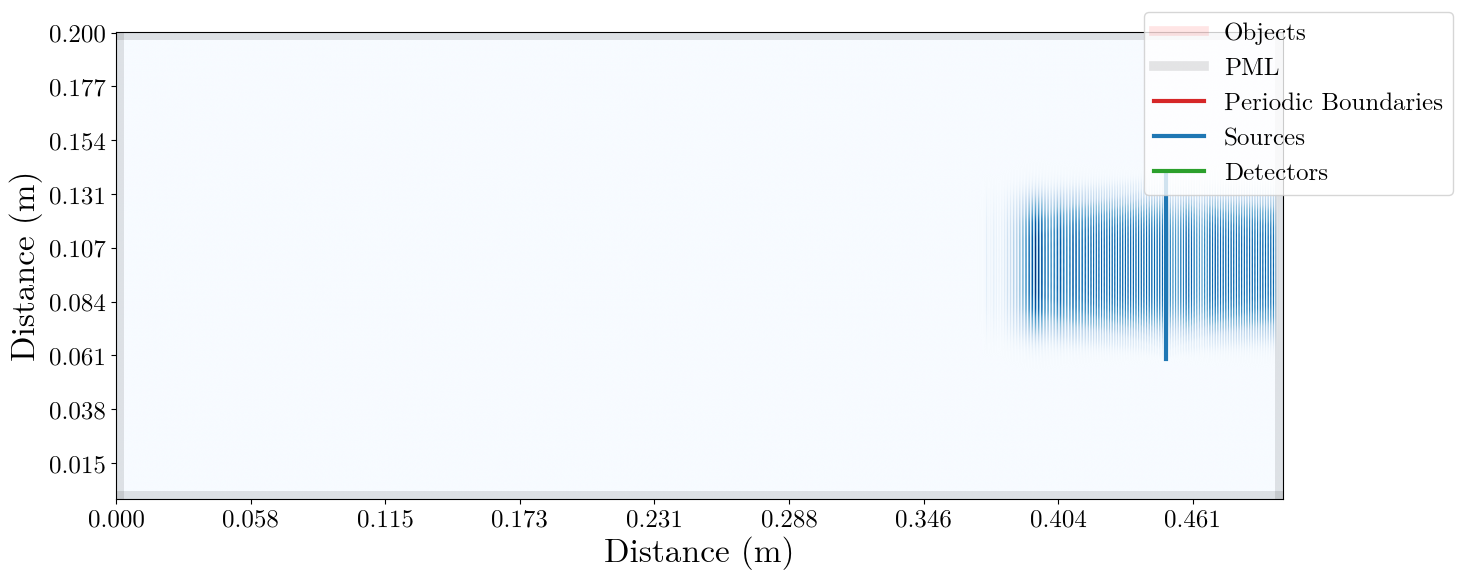

In [11]:
grid.visualize(cmap="Blues",z=0,index=1,scale=2,save=True,folder="./")

In [12]:
E_xy=(grid.E[:, :, 0, 0]**2+grid.E[:, :, 0, 1]**2)**0.5
E_z=(grid.E[:, :, 0, 2]**2)**0.5
E_norm=bd.numpy(bd.sqrt((grid.E ** 2).sum(axis=-1)))
E_norm/=np.max(E_norm)+1e-20
J_norm=bd.numpy(bd.sqrt((grid.J ** 2).sum(axis=-1)))
J_norm/=np.max(J_norm)+1e-20
J_norm_log=np.log(J_norm+1e-2)/np.log(10)
S=bd.cross(grid.E,grid.H)
S_norm=bd.numpy(bd.sqrt((S ** 2).sum(axis=-1)))
S_norm/=np.max(S_norm)+1e-20
omega=bd.numpy(grid.omega[:,:,:,0])*1e-9
OMEGA=bd.numpy(bd.sqrt((grid.OMEGA ** 2).sum(axis=-1)))*1e-9
log_div_E=np.log(bd.numpy((bd.abs(divergence(grid.E))+1e-10)/(bd.norm(grid.E)+1e-10)+1e-10)/grid.grid_spacing)/np.log(10)
log_div_H=np.log(bd.numpy((bd.abs(divergence(grid.H))+1e-10)/(bd.norm(grid.H)+1e-10)+1e-10)/grid.grid_spacing)/np.log(10)


In [13]:
def printout(S,ax,title,colormap=plt.cm.Reds,plot_resonance=False):
    # Plot your electric field
    im = ax.imshow(S, cmap=colormap, origin='lower')
    im.set_interpolation('bicubic')

    if plot_resonance is True:
        # Overlay equi-cutoff contour(s)
        f_target = FREQUENCY  # example cutoff frequency (change this)
        # Draw contour where cutoff = f_target
        CS = ax.contour(
            cutoffs, 
            levels=[f_target], 
            colors='black',     # color of contour
            linewidths=1, 
            linestyles=':'
        )
        # Optional: label the contour with its frequency
        ax.clabel(
            CS,
            inline=False,
            fontsize=12,
            fmt=lambda x: f"{x/1e9:.1f} GHz",
            manual=[(30, 80)],   # optional: manually place label
            rightside_up=True
        )
        for txt in CS.labelTexts:
            txt.set_rotation(0)  # rotate 45 degrees
    
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda val, pos: f"{7.75+val*grid.grid_spacing:.1f}"))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda val, pos: f"{val*grid.grid_spacing:.1f}"))
    
    # Add colorbar and labels
    cb = ax.figure.colorbar(im, ax=ax, orientation='vertical', location ='right', pad=0.01)
    cb.ax.set_ylabel(title, size=17,rotation=-90)
    cb.ax.yaxis.set_label_coords(16, .5)
    # ax.set_xlabel('x (m)', rotation=0)
    # ax.set_ylabel('y (cm)', rotation=90)
    ax.locator_params(axis='y', nbins=4)
    ax.locator_params(axis='x', nbins=3)


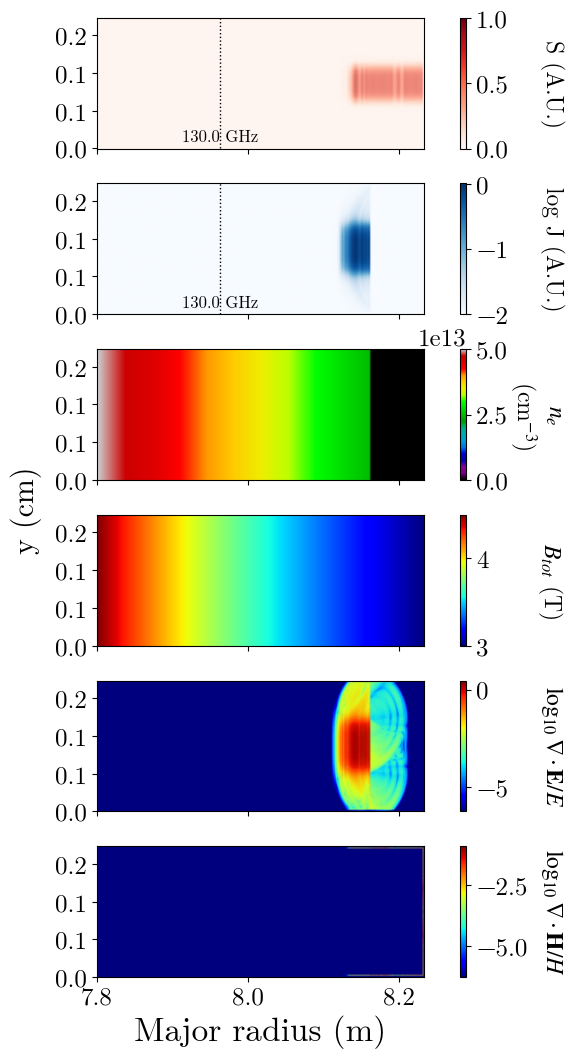

In [14]:
fig, axs = plt.subplots(6,figsize=(36,10),sharex=True)
printout(S_norm,axs[0],"S (A.U.)",plt.cm.Reds,plot_resonance=True)    
printout(J_norm_log,axs[1],"log J (A.U.)",plt.cm.Blues,plot_resonance=True) 
# printout(omega/2./3.1416,axs[2],"$\\omega_{pe}$ (GHz)",plt.cm.nipy_spectral) 
# printout(OMEGA/2./3.1416,axs[3],"$\\Omega_e$ (GHz)",plt.cm.nipy_spectral)
printout(bd.numpy(grid.n_e[:,:,0,0])/1e6,axs[2],"$n_e$\n(cm$^{-3}$)",plt.cm.nipy_spectral)
printout(bd.numpy(grid.B_T[:,:,0,0]),axs[3],"$B_{tot}$ (T)",plt.cm.jet)
printout(log_div_E[:,:,0,0],axs[4],r'$\log_{10} \nabla\cdot\mathbf{E}/E$',plt.cm.jet)
printout(log_div_H[:,:,0,0],axs[5],r'$\log_{10} \nabla\cdot\mathbf{H}/H$',plt.cm.jet)
plt.subplots_adjust(
    wspace=0.001,  # horizontal space between subplots
    hspace=0.1   # vertical space between subplots
)
fig.tight_layout(pad=0.003)
plt.xlabel('Major radius (m)',rotation=0)
fig.supylabel('y (cm)', rotation=90,position=(.725,.5))

# plt.suptitle('$\\omega_0$ = '+f"{FREQUENCY*1e-9:.1f}"+' GHz',position=(.85,1.1),size=20)
plt.savefig("out.png", 
               bbox_inches='tight', 
               transparent=False,
               pad_inches=.1)
plt.show()

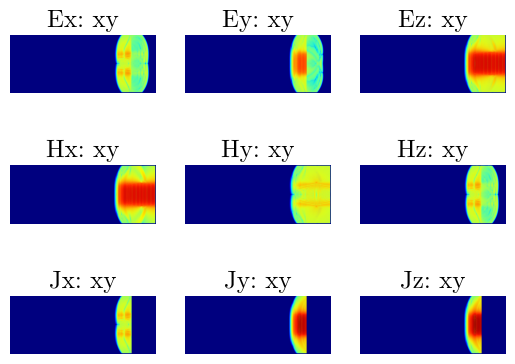

In [15]:
fig, axes = plt.subplots(3, 3, squeeze=False)
titles = ["Ex: xy", "Ey: xy", "Ez: xy", "Hx: xy", "Hy: xy", "Hz: xy", "Jx: xy", "Jy: xy", "Jz: xy"]
log_bias=1e-18
fields = bd.stack(
    [
        bd.log(grid.E[:, :, 0, 0]**2+log_bias)/2./log(10.),
        bd.log(grid.E[:, :, 0, 1]**2+log_bias)/2./log(10.),
        bd.log(grid.E[:, :, 0, 2]**2+log_bias)/2./log(10.),
        bd.log(grid.H[:, :, 0, 0]**2+log_bias)/2./log(10.),
        bd.log(grid.H[:, :, 0, 1]**2+log_bias)/2./log(10.),
        bd.log(grid.H[:, :, 0, 2]**2+log_bias)/2./log(10.),
        bd.log(grid.J[:, :, 0, 0]**2+log_bias)/2./log(10.),
        bd.log(grid.J[:, :, 0, 1]**2+log_bias)/2./log(10.),
        bd.log(grid.J[:, :, 0, 2]**2+log_bias)/2./log(10.),
    ]
)

mini = fields.min().item()
maxi = fields.max().item()

for ax, field, title in zip(axes.ravel(), fields, titles):
    ax.set_axis_off()
    ax.set_title(title)
    ax.imshow(bd.numpy(field), vmin=mini, vmax=maxi, cmap="jet")

plt.savefig("array.png", 
               bbox_inches='tight', 
               transparent=True,
               pad_inches=0)

plt.show()